# 如何切换不同的模型？

## 在init中切换模型 

通过指定init函数中的model关键字，来切换模型

In [ ]:
import flgo
import os
import flgo.benchmark.mnist_classification.model.cnn as cnn
import flgo.benchmark.mnist_classification.model.mlp as mlp
import flgo.algorithm.fedavg as fedavg

# 设置联邦任务，如果任务不存在，取消注释下面两行代码生成该任务
task = './test_mnist'
config = {'benchmark':{'name':'flgo.benchmark.mnist_classification'},'partitioner':{'name': 'IIDPartitioner','para':{'num_clients':100}}}
if not os.path.exists(task): flgo.gen_task(config, task_path = task)

cnn_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=cnn)
mlp_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=mlp)
cnn_runner.run()
mlp_runner.run()

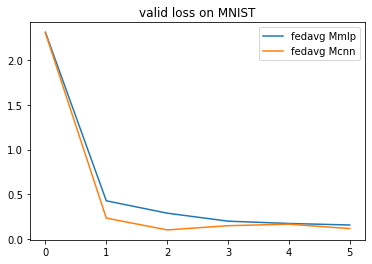

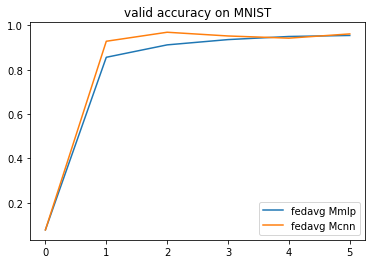

In [3]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg'],
        'filter':{'M':['cnn', 'mlp']},
        'legend_with':['M']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on MNIST'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on MNIST'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)

## 如何自定义模型？ 

在FLGo中，我们将模型视作benchmark所包含的一部分。这是因为对于不同的数据集来说，模型的架构往往不一致，且同一个数据集也可以使用不同的模型。因此，每个benchmark都必须具有benchmark_name.model子模块，且子模块中需要包含适用于该benchmark的模型（例如mnist_classification.model.cnn）。

考虑到纵向、横向、个性化、合作公平等不同形式联邦的差异和需求，我们以mnist_classification.model.cnn为例，讲解FLGo中模型是被定义和初始化的。

In [4]:
from torch import nn
import torch.nn.functional as F
from flgo.utils.fmodule import FModule

class Model(FModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(3136, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.get_embedding(x)
        x = self.fc2(x)
        return x

    def get_embedding(self, x):
        x = x.view((x.shape[0],28,28))
        x = x.unsqueeze(1)
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        return x

def init_local_module(object):
    pass

def init_global_module(object):
    if 'Server' in object.__class__.__name__:
        object.model = Model().to(object.device)

class MyCNN:
    init_local_module = init_local_module
    init_global_module = init_global_module

在FLGo中，主要通过重写model.init_local_module接口和model.init_global_module接口，来为每个实体object（例如，横向联邦中Server或Client的实例）分配模型。其中：

* **init_local_module**是为实体分配自身所持有的本地模型（例如personalized models）
* **init_global_module**是为实体分配用于共享的全局模型（例如经典横向联邦中的global model）

由于经典横向联邦中只需要服务器维护最新的全局模型，因此上面代码中init_global_module中只为类别为Server的实例设置一个全局模型，而所有其他实体不持有模型。

In [ ]:
mycnn_runner = flgo.init(task, fedavg, option={'num_rounds':5, 'num_epochs':1, 'gpu':0}, model=MyCNN)
mycnn_runner.run()

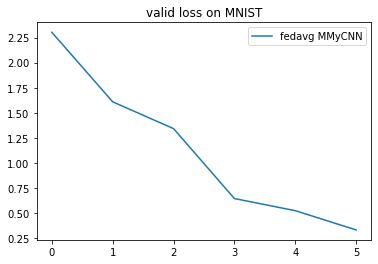

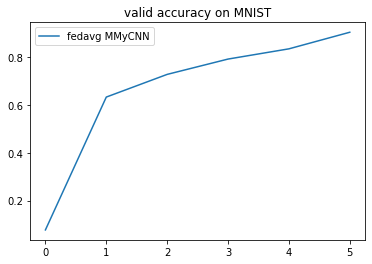

In [8]:
import flgo.experiment.analyzer
analysis_plan = {
    'Selector':{
        'task': task,
        'header':['fedavg'],
        'filter':{'M':['MyCNN']},
        'legend_with':['M']
    },
    'Painter':{
        'Curve':[
            {'args':{'x': 'communication_round', 'y':'val_loss'}, 'fig_option':{'title':'valid loss on MNIST'}},
            {'args':{'x': 'communication_round', 'y':'val_accuracy'},  'fig_option':{'title':'valid accuracy on MNIST'}},
        ]
    }
}
flgo.experiment.analyzer.show(analysis_plan)